In [1]:
import pandas as pd
import polars as pl
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from collections import defaultdict
import warnings
from tqdm import tqdm
import pickle
from datetime import datetime
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

tqdm.pandas()
warnings.filterwarnings("ignore")

In [2]:
year = 20
df = f"../data/CampaignFin{year}/indivs{year}.txt"
donors_csv = f"../data/CampaignFin{year}/donors_state{year}.csv"

In [3]:
donors = pd.read_csv(donors_csv)
donors["firstname"] = donors["name"].apply(lambda x: str(x).split(",")[-1].lower().strip())
donors["lastname"] = donors["name"].apply(lambda x: str(x).split(",")[0].lower().strip())
donors.head(10)

,contrib_id,name,name_new,orgname,ultorg,realcode,gender,occupation,employer,city,state,total_donated,donation_count,avg_donation,med_donation,firstname,lastname
0,,ACTBLUE,actblue actblue,NaN,NaN,Y4000,,NaN,NaN,WASHINGTON,CA,1.261253e+09,25821,4.884603e+04,1000.0,actblue,actblue
1,U00000037041,"BLOOMBERG, MICHAEL R",michael r bloomberg,[Candidate Contribution],NaN,Z9000,M,FOUNDER,BLOOMBERG INC.,NEW YORK,NY,1.127731e+09,958,1.177172e+06,682.5,michael r,bloomberg
2,U00000036521,"STEYER, TOM",tom steyer,[Candidate Contribution],NaN,Z9000,M,PRESIDENTIAL CANDIDATE,SELF-EMPLOYED,SAN FRANCISCO,CA,3.794782e+08,756,5.019553e+05,2800.0,tom,steyer
3,U00000046841,"MELLON, TIMOTHY",timothy mellon,Investments,NaN,F7000,M,INVESTMENTS,SELF-EMPLOYED,SARATOGA,WY,4.513356e+07,23,1.962328e+06,2800.0,timothy,mellon
4,U0000000310A,"ADELSON, MIRIAM",miriam adelson,Adelson Clinic for Drug Abuse Treatment & Rese...,NaN,H3200,F,PHYSICIAN,ADELSON CLINIC,LAS VEGAS,NV,4.499955e+07,124,3.628996e+05,2800.0,miriam,adelson
5,U00000003101,"ADELSON, SHELDON G",sheldon g adelson,Las Vegas Sands,NaN,G6500,M,CEO,LAS VEGAS SANDS CORPORATION,LAS VEGAS,NV,4.484795e+07,119,3.768735e+05,2800.0,sheldon g,adelson
6,U00000036901,"UIHLEIN, RICHARD",richard uihlein,Uline Inc,NaN,M7000,M,CEO,ULINE,LAKE FOREST,IL,3.536433e+07,319,1.108600e+05,2800.0,richard,uihlein
7,U00000036551,"GRIFFIN, KENNETH",kenneth griffin,Citadel LLC,NaN,F2700,M,FOUNDER CEO,CITADEL LLC,CHICAGO,IL,3.366763e+07,188,1.790832e+05,2800.0,kenneth,griffin
8,U00000003611,"SCHWARZMAN, STEPHEN A",stephen a schwarzman,Blackstone Group,NaN,F2600,M,CHAIRMAN,BLACKSTONE,NEW YORK,NY,3.345400e+07,226,1.480265e+05,2800.0,stephen a,schwarzman
9,U00000046781,"JURVETSON, KARLA",karla jurvetson,Karla T Jurvetson MD,NaN,H1110,F,PHYSICIAN,SELF,LOS ALTOS,CA,3.308810e+07,914,3.620142e+04,2800.0,karla,jurvetson


In [4]:
firstname_ratios = pd.read_csv("../output/USIN_firstnames_ratios.csv")
lastname_ratios = pd.read_csv("../output/USIN_lastnames_ratios.csv")

In [5]:
firstname_ratio_dict = firstname_ratios.set_index(firstname_ratios['firstname'].str.strip().str.lower())['ratio'].to_dict()
lastname_ratio_dict = lastname_ratios.set_index(lastname_ratios['lastname'].str.strip().str.lower())['ratio'].to_dict()

donors['combined_ratio'] = (
    donors['firstname'].map(firstname_ratio_dict).fillna(0) + 
    donors['lastname'].map(lastname_ratio_dict).fillna(0)
)

In [6]:
# get the most common indian last names
indian_firstnames = set(firstname_ratios[firstname_ratios["ratio"] >= 8]["firstname"].str.lower())
indian_lastnames = set(lastname_ratios[lastname_ratios["ratio"] >= 5]["lastname"].str.lower())
unindian_firstnames = set(firstname_ratios[firstname_ratios["ratio"] <= 0.05]["firstname"].str.lower())
unindian_lastnames = set(lastname_ratios[lastname_ratios["ratio"] <= 0.05]["lastname"].str.lower())

In [7]:
donors["indian_first"] = np.where(donors["firstname"].str.lower().isin(indian_firstnames) & ~donors["lastname"].str.lower().isin(unindian_lastnames), True, False)
donors["indian_last"] = np.where(donors["lastname"].str.lower().isin(indian_lastnames) & ~donors["firstname"].str.lower().isin(unindian_firstnames), True, False)
donors["indian"] = np.where((donors["combined_ratio"] >= 15) | (donors["indian_first"] == True) | (donors["indian_last"] == True), True, False)
donors["indian"].value_counts()

indian
False    3545523
True       43413
Name: count, dtype: int64

In [8]:
# https://github.com/philipperemy/name-dataset
'''df_us = pd.read_csv("../data/US.csv")
df_us.columns = ['firstname', 'lastname', 'gender', 'ethnicity']
df_us['firstname'] = df_us['firstname'].apply(lambda x: x.split(" ")[0].strip() if " " in str(x) else str(x).strip())
df_us['lastname'] = df_us['lastname'].apply(lambda x: x.split(" ")[-1].strip() if " " in str(x) else str(x).strip())
df_us['name'] = df_us['firstname'].apply(lambda x: x.lower()) + ' ' + df_us['lastname'].apply(lambda x: x.lower())
df_us["indian"] = df_us["ethnicity"].apply(lambda x: False)

df_us = df_us[
    (df_us['firstname'].str.match(r'^[A-Za-z]+$', na=False)) & 
    (df_us['firstname'].str.len() > 1) &
    (df_us['firstname'].str.lower() != 'nan') &
    (df_us['lastname'].str.match(r'^[A-Za-z]+$', na=False)) &
    (df_us['lastname'].str.len() > 1) &
    (df_us['lastname'].str.lower() != 'nan')
]

df_us = df_us[['firstname', 'lastname', 'name', 'indian']]
df_us.head(10)'''

'df_us = pd.read_csv("../data/US.csv")\ndf_us.columns = [\'firstname\', \'lastname\', \'gender\', \'ethnicity\']\ndf_us[\'firstname\'] = df_us[\'firstname\'].apply(lambda x: x.split(" ")[0].strip() if " " in str(x) else str(x).strip())\ndf_us[\'lastname\'] = df_us[\'lastname\'].apply(lambda x: x.split(" ")[-1].strip() if " " in str(x) else str(x).strip())\ndf_us[\'name\'] = df_us[\'firstname\'].apply(lambda x: x.lower()) + \' \' + df_us[\'lastname\'].apply(lambda x: x.lower())\ndf_us["indian"] = df_us["ethnicity"].apply(lambda x: False)\n\ndf_us = df_us[\n    (df_us[\'firstname\'].str.match(r\'^[A-Za-z]+$\', na=False)) & \n    (df_us[\'firstname\'].str.len() > 1) &\n    (df_us[\'firstname\'].str.lower() != \'nan\') &\n    (df_us[\'lastname\'].str.match(r\'^[A-Za-z]+$\', na=False)) &\n    (df_us[\'lastname\'].str.len() > 1) &\n    (df_us[\'lastname\'].str.lower() != \'nan\')\n]\n\ndf_us = df_us[[\'firstname\', \'lastname\', \'name\', \'indian\']]\ndf_us.head(10)'

In [9]:
'''total_names = len(df_us)

firstname_counts = df_us['firstname'].value_counts().reset_index().rename(columns={'count': 'firstname_count'})
firstname_counts['firstname_rate'] = (firstname_counts['firstname_count'] / len(df_us)) * 100

lastname_counts = df_us['lastname'].value_counts().reset_index().rename(columns={'count': 'lastname_count'})
lastname_counts['lastname_rate'] = (lastname_counts['lastname_count'] / len(df_us)) * 100

df_us = df_us.merge(firstname_counts[['firstname', 'firstname_count', 'firstname_rate']], on='firstname', how='left')
df_us = df_us.merge(lastname_counts[['lastname', 'lastname_count', 'lastname_rate']], on='lastname', how='left')
df_us'''

"total_names = len(df_us)\n\nfirstname_counts = df_us['firstname'].value_counts().reset_index().rename(columns={'count': 'firstname_count'})\nfirstname_counts['firstname_rate'] = (firstname_counts['firstname_count'] / len(df_us)) * 100\n\nlastname_counts = df_us['lastname'].value_counts().reset_index().rename(columns={'count': 'lastname_count'})\nlastname_counts['lastname_rate'] = (lastname_counts['lastname_count'] / len(df_us)) * 100\n\ndf_us = df_us.merge(firstname_counts[['firstname', 'firstname_count', 'firstname_rate']], on='firstname', how='left')\ndf_us = df_us.merge(lastname_counts[['lastname', 'lastname_count', 'lastname_rate']], on='lastname', how='left')\ndf_us"

In [10]:
'''# https://github.com/philipperemy/name-dataset
df_indian = pd.read_csv("../data/IN.csv")
df_indian.columns = ['firstname', 'lastname', 'gender', 'ethnicity']
df_indian['firstname'] = df_indian['firstname'].apply(lambda x: x.split(" ")[0].strip() if " " in str(x) else str(x).strip())
df_indian['lastname'] = df_indian['lastname'].apply(lambda x: x.split(" ")[-1].strip() if " " in str(x) else str(x).strip())
df_indian['name'] = df_indian['firstname'].apply(lambda x: x.lower()) + ' ' + df_indian['lastname'].apply(lambda x: x.lower())
df_indian["indian"] = df_indian["ethnicity"].apply(lambda x: True)

df_indian = df_indian[
    (df_indian['firstname'].str.match(r'^[A-Za-z]+$', na=False)) & 
    (df_indian['firstname'].str.len() > 1) &
    (df_indian['firstname'].str.lower() != 'nan') &
    (df_indian['lastname'].str.match(r'^[A-Za-z]+$', na=False)) &
    (df_indian['lastname'].str.len() > 1) &
    (df_indian['lastname'].str.lower() != 'nan')
]

df_indian = df_indian[['firstname', 'lastname', 'name', 'indian']]
df_indian.head(10)'''

'# https://github.com/philipperemy/name-dataset\ndf_indian = pd.read_csv("../data/IN.csv")\ndf_indian.columns = [\'firstname\', \'lastname\', \'gender\', \'ethnicity\']\ndf_indian[\'firstname\'] = df_indian[\'firstname\'].apply(lambda x: x.split(" ")[0].strip() if " " in str(x) else str(x).strip())\ndf_indian[\'lastname\'] = df_indian[\'lastname\'].apply(lambda x: x.split(" ")[-1].strip() if " " in str(x) else str(x).strip())\ndf_indian[\'name\'] = df_indian[\'firstname\'].apply(lambda x: x.lower()) + \' \' + df_indian[\'lastname\'].apply(lambda x: x.lower())\ndf_indian["indian"] = df_indian["ethnicity"].apply(lambda x: True)\n\ndf_indian = df_indian[\n    (df_indian[\'firstname\'].str.match(r\'^[A-Za-z]+$\', na=False)) & \n    (df_indian[\'firstname\'].str.len() > 1) &\n    (df_indian[\'firstname\'].str.lower() != \'nan\') &\n    (df_indian[\'lastname\'].str.match(r\'^[A-Za-z]+$\', na=False)) &\n    (df_indian[\'lastname\'].str.len() > 1) &\n    (df_indian[\'lastname\'].str.lower() !=

In [11]:
'''total_names = len(df_indian)

firstname_counts = df_indian['firstname'].value_counts().reset_index().rename(columns={'count': 'firstname_count'})
firstname_counts['firstname_rate'] = (firstname_counts['firstname_count'] / len(df_indian)) * 100

lastname_counts = df_indian['lastname'].value_counts().reset_index().rename(columns={'count': 'lastname_count'})
lastname_counts['lastname_rate'] = (lastname_counts['lastname_count'] / len(df_indian)) * 100

df_indian = df_indian.merge(firstname_counts[['firstname', 'firstname_count', 'firstname_rate']], on='firstname', how='left')
df_indian = df_indian.merge(lastname_counts[['lastname', 'lastname_count', 'lastname_rate']], on='lastname', how='left')
df_indian'''

"total_names = len(df_indian)\n\nfirstname_counts = df_indian['firstname'].value_counts().reset_index().rename(columns={'count': 'firstname_count'})\nfirstname_counts['firstname_rate'] = (firstname_counts['firstname_count'] / len(df_indian)) * 100\n\nlastname_counts = df_indian['lastname'].value_counts().reset_index().rename(columns={'count': 'lastname_count'})\nlastname_counts['lastname_rate'] = (lastname_counts['lastname_count'] / len(df_indian)) * 100\n\ndf_indian = df_indian.merge(firstname_counts[['firstname', 'firstname_count', 'firstname_rate']], on='firstname', how='left')\ndf_indian = df_indian.merge(lastname_counts[['lastname', 'lastname_count', 'lastname_rate']], on='lastname', how='left')\ndf_indian"

In [12]:
'''df_combined = pd.concat([df_us, df_indian], ignore_index=True)
df_combined.to_csv("../output/USIN.csv", index=False)'''

'df_combined = pd.concat([df_us, df_indian], ignore_index=True)\ndf_combined.to_csv("../output/USIN.csv", index=False)'

In [13]:
df = pd.read_csv("../output/USIN.csv")
df

,firstname,lastname,name,indian,firstname_count,firstname_rate,lastname_count,lastname_rate
0,Brandon,Sylvester,brandon sylvester,False,58421,0.189127,1272,0.004118
1,Chris,Toussaint,chris toussaint,False,131039,0.424215,1691,0.005474
2,Willie,Gotti,willie gotti,False,10987,0.035568,693,0.002243
3,Cristobal,Corona,cristobal corona,False,2640,0.008547,9672,0.031311
4,Wilmer,Diaz,wilmer diaz,False,4269,0.013820,91634,0.296648
...,...,...,...,...,...,...,...,...
36734983,Vikas,Chakchanpur,vikas chakchanpur,True,8871,0.151765,1,0.000017
36734984,Dipu,Gupta,dipu gupta,True,1526,0.026107,43396,0.742419
36734985,Riya,Naharwal,riya naharwal,True,6367,0.108927,8,0.000137
36734986,Jashandeep,Hanjra,jashandeep hanjra,True,17,0.000291,43,0.000736


In [8]:
def create_train_features(train_data_label, output_file_path="USIN_features.csv"):
    # --------------------
    # Load Data
    # --------------------
    
    path = f"../output/yearly/donors_{train_data_label}_pred_lastname.csv"
    train_data = pd.read_csv(path)
        
    train_data['id'] = range(1, len(train_data) + 1)
    
    # Clean data
    train_data['firstname'] = train_data['firstname'].apply(lambda x: str(x).split(" ")[0])
    train_data = train_data.dropna(subset=['firstname', 'lastname', 'indian'])
    
    # --------------------
    # Cutpoints
    # --------------------
    
    c = 1
    cutl = 10
    
    # --------------------
    # Feature Creation
    # --------------------
    
    # 1. First four letters of the first/last name:
    train_data['first_name_f4'] = train_data['firstname'].str[:4]
    train_data['last_name_f4'] = train_data['lastname'].str[:4]
    
    # First Names - Indian probability
    indian_count_fn = train_data[train_data['indian'] == True].groupby('first_name_f4').size()
    indian_count_fn.name = 'pop_indian_f4'
    train_data = train_data.merge(indian_count_fn, how='left', on='first_name_f4')
    
    mean_pop = train_data.groupby('first_name_f4')['pop_indian_f4'].transform('mean')
    count = train_data.groupby('first_name_f4')['pop_indian_f4'].transform('count')
    train_data['pop_fn_indian_f4'] = mean_pop / (count + c)
    
    # Last Names - Indian probability
    indian_count_ln = train_data[train_data['indian'] == True].groupby('last_name_f4').size()
    indian_count_ln.name = 'pop_indian_f4_ln'
    train_data = train_data.merge(indian_count_ln, how='left', on='last_name_f4')
    
    mean_pop = train_data.groupby('last_name_f4')['pop_indian_f4_ln'].transform('mean')
    count = train_data.groupby('last_name_f4')['pop_indian_f4_ln'].transform('count')
    train_data['pop_ln_indian_f4'] = mean_pop / count
    
    train_data = train_data.drop(columns=['pop_indian_f4', 'pop_indian_f4_ln'])
    train_data = train_data.fillna(0)
    
    # 2. Last four letters of the first/last name:
    train_data['first_name_l4'] = train_data['firstname'].str[-4:]
    train_data['last_name_l4'] = train_data['lastname'].str[-4:]
    
    # First Names - Indian probability
    indian_count_fn = train_data[train_data['indian'] == True].groupby('first_name_l4').size()
    indian_count_fn.name = 'pop_indian_l4'
    train_data = train_data.merge(indian_count_fn, how='left', on='first_name_l4')
    
    mean_pop = train_data.groupby('first_name_l4')['pop_indian_l4'].transform('mean')
    count = train_data.groupby('first_name_l4')['pop_indian_l4'].transform('count')
    train_data['pop_fn_indian_l4'] = mean_pop / (count + c)
    
    # Last Names - Indian probability
    indian_count_ln = train_data[train_data['indian'] == True].groupby('last_name_l4').size()
    indian_count_ln.name = 'pop_indian_l4_ln'
    train_data = train_data.merge(indian_count_ln, how='left', on='last_name_l4')
    
    mean_pop = train_data.groupby('last_name_l4')['pop_indian_l4_ln'].transform('mean')
    count = train_data.groupby('last_name_l4')['pop_indian_l4_ln'].transform('count')
    train_data['pop_ln_indian_l4'] = mean_pop / (count + c)
    
    train_data = train_data.drop(columns=['pop_indian_l4', 'pop_indian_l4_ln'])
    train_data = train_data.fillna(0)
    
    # 3. Full first/last name:
    # First Names - Indian probability
    indian_count_fn = train_data[train_data['indian'] == True].groupby('firstname').size()
    indian_count_fn.name = 'pop_indian_fn'
    train_data = train_data.merge(indian_count_fn, how='left', on='firstname')
    
    mean_pop = train_data.groupby('firstname')['pop_indian_fn'].transform('mean')
    count = train_data.groupby('firstname')['pop_indian_fn'].transform('count')
    train_data['pop_fn_indian'] = mean_pop / (count + c)
    
    # Last Names - Indian probability
    indian_count_ln = train_data[train_data['indian'] == True].groupby('lastname').size()
    indian_count_ln.name = 'pop_indian_ln'
    train_data = train_data.merge(indian_count_ln, how='left', on='lastname')
    
    mean_pop = train_data.groupby('lastname')['pop_indian_ln'].transform('mean')
    count = train_data.groupby('lastname')['pop_indian_ln'].transform('count')
    train_data['pop_ln_indian'] = mean_pop / (count + c)
    
    train_data = train_data.drop(columns=['pop_indian_fn', 'pop_indian_ln'])
    train_data = train_data.fillna(0)
    
    # Indicator Low Frequency of Name:
    train_data['first_name_low'] = (train_data.groupby('firstname')['firstname'].transform('count') < cutl).astype(int)
    train_data['last_name_low'] = (train_data.groupby('lastname')['lastname'].transform('count') < cutl).astype(int)
    
    # Best Evidence
    train_data['best_evidence_indian'] = train_data[['pop_ln_indian', 'pop_fn_indian']].max(axis=1)
    
    # Select final columns
    final_columns = [
        'id', 'firstname', 'lastname', 'indian', 
        'first_name_f4', 'first_name_l4',
        'last_name_f4', 'last_name_l4',
        'pop_ln_indian', 'pop_fn_indian',
        'best_evidence_indian',
        'pop_ln_indian_f4', 'pop_fn_indian_f4',
        'pop_ln_indian_l4', 'pop_fn_indian_l4',
        'last_name_low', 'first_name_low'
    ]
    
    train_data = train_data[final_columns]
    
    # Save output
    output_file_path = f"../data/donors{train_data_label}_{output_file_path}"
    train_data.to_csv(output_file_path, index=False)
    
    return train_data

In [15]:
# create_train_features(str(year))
output_path = f"../data/donors{year}_USIN_features.csv"
features = pd.read_csv(output_path)
features

,id,firstname,lastname,indian,first_name_f4,first_name_l4,last_name_f4,last_name_l4,pop_ln_indian,pop_fn_indian,best_evidence_indian,pop_ln_indian_f4,pop_fn_indian_f4,pop_ln_indian_l4,pop_fn_indian_l4,last_name_low,first_name_low
0,1,actblue,actblue,False,actb,blue,actb,blue,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,1
1,2,michael,bloomberg,False,mich,hael,bloo,berg,0.000000,0.001818,0.001818,0.000000,0.001930,0.000404,0.001825,0,0
2,3,tom,steyer,False,tom,tom,stey,eyer,0.000000,0.000903,0.000903,0.000000,0.000903,0.000175,0.000903,0,0
3,4,timothy,mellon,False,timo,othy,mell,llon,0.000000,0.001856,0.001856,0.005252,0.001843,0.044110,0.002094,0,0
4,5,miriam,adelson,False,miri,riam,adel,lson,0.000000,0.000805,0.000805,0.002618,0.000775,0.000659,0.003446,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3588744,3588932,elizabeth,english,False,eliz,beth,engl,lish,0.001623,0.002059,0.002059,0.001106,0.002022,0.002060,0.002251,0,0
3588745,3588933,linda,rapp,False,lind,inda,rapp,rapp,0.000000,0.001796,0.001796,0.000000,0.001779,0.000000,0.002167,0,0
3588746,3588934,julie,oldham,False,juli,ulie,oldh,dham,0.000000,0.001888,0.001888,0.000000,0.002424,0.009736,0.001882,0,0
3588747,3588935,nancy,martin,False,nanc,ancy,mart,rtin,0.000873,0.001560,0.001560,0.000792,0.001580,0.000780,0.001601,0,0


In [9]:
def process_data_set_indian(features, num_rows=100000, full_data=False):

    features = features.dropna(subset=['firstname', 'lastname', 'indian'])
    features.fillna(0, inplace=True)
    
    if not full_data:
        features = features.sample(n=num_rows, random_state=42)
    
    features.reset_index(drop=True, inplace=True)
    
    
    first_name_encoder = LabelEncoder()
    X_first_name = first_name_encoder.fit_transform(features['firstname'].fillna('unknown'))
    
    last_name_encoder = LabelEncoder()
    X_last_name = last_name_encoder.fit_transform(features['lastname'].fillna('unknown'))
    
    for col in ['first_name_f4', 'last_name_f4', 'first_name_l4', 'last_name_l4']:
        if col in features.columns:
            features[col] = features[col].astype(str)
    
    first_name_f4_encoder = LabelEncoder()
    X_first_name_f4 = first_name_f4_encoder.fit_transform(features['first_name_f4'].fillna('unknown'))
    
    last_name_f4_encoder = LabelEncoder()
    X_last_name_f4 = last_name_f4_encoder.fit_transform(features['last_name_f4'].fillna('unknown'))    
    
    first_name_l4_encoder = LabelEncoder()
    X_first_name_l4 = first_name_l4_encoder.fit_transform(features['first_name_l4'].fillna('unknown'))
    
    last_name_l4_encoder = LabelEncoder()
    X_last_name_l4 = last_name_l4_encoder.fit_transform(features['last_name_l4'].fillna('unknown'))
    
    # Add encoded names as features
    features['first_name_encoded'] = X_first_name
    features['last_name_encoded'] = X_last_name
    features['first_name_f4_encoded'] = X_first_name_f4
    features['last_name_f4_encoded'] = X_last_name_f4
    features['first_name_l4_encoded'] = X_first_name_l4
    features['last_name_l4_encoded'] = X_last_name_l4
    
    # Keep relevant columns
    main_features = features[['firstname', 'lastname', 'indian', 'id', 
                             'first_name_encoded', 'last_name_encoded',
                             'first_name_f4_encoded', 'last_name_f4_encoded',
                             'first_name_l4_encoded', 'last_name_l4_encoded']]
    y = main_features['indian'].astype(int)
    X = main_features.drop(['id', 'firstname', 'lastname', 'indian'], axis=1, errors='ignore')
    
    print(f"X shape = {X.shape}, y shape = {y.shape}")
    print(f"Indian count: {y.sum()}, Non-Indian count: {len(y) - y.sum()}")
    
    return X, y, main_features, (first_name_encoder, last_name_encoder,
            first_name_f4_encoder, last_name_f4_encoder,
            first_name_l4_encoder, last_name_l4_encoder)

In [60]:
X, y, main_features, encoders = process_data_set_indian(features, num_rows=1, full_data=True)
X

X shape = (3587209, 6), y shape = (3587209,)
Indian count: 43220, Non-Indian count: 3543989


,first_name_encoded,last_name_encoded,first_name_f4_encoded,last_name_f4_encoded,first_name_l4_encoded,last_name_l4_encoded
0,656,2160,293,458,3309,5876
1,59248,39073,15668,4795,8431,5513
2,88498,383238,23738,41539,22257,12950
3,88136,262404,23571,28035,17730,24136
4,60162,2597,15816,517,19288,24723
...,...,...,...,...,...,...
3587204,24747,115509,6401,12261,3136,23878
3587205,51619,325882,14257,36826,10475,34283
3587206,42924,292638,12054,32622,23221,8656
3587207,62628,251703,16614,27425,1653,36515


In [10]:
def train_indian_classifier(train_data_label, X_train, y_train, encoders, epochs=5):
    print("date and time =", datetime.now().strftime("%d/%m/%Y %H:%M:%S"))

    best_loss = 999999999
    patience = 1
    patience_counter = 0
    early_stop = False
    batch_size = 1024
    
    vocab_sizes = [len(encoder.classes_) for encoder in encoders]
    print(f"First name vocabulary size: {vocab_sizes[0]}")
    print(f"Last name vocabulary size: {vocab_sizes[1]}")
    
    X_numeric = X_train.values.astype(np.float32)
    print(f"Using {X_numeric.shape[1]} numeric features + character embeddings")
    
    X_numeric_tensor = torch.tensor(X_numeric, dtype=torch.float32)
    y_tensor = torch.tensor(y_train.values.astype(np.float32), dtype=torch.float32)
    
    encoded_indices = {}
    for col in ['first_name_encoded', 'last_name_encoded', 
                'first_name_f4_encoded', 'last_name_f4_encoded',
                'first_name_l4_encoded', 'last_name_l4_encoded']:
        encoded_indices[col] = X_train.columns.get_loc(col)
    
    dataset = TensorDataset(X_numeric_tensor, y_tensor)
    train_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
    
    numeric_dim = X_numeric.shape[1] - len(encoded_indices)
    embedding_dim = 32
    hidden_dim = 128
    
    embedding_layers = {
        'first_name': nn.Embedding(vocab_sizes[0] + 10, embedding_dim),
        'last_name': nn.Embedding(vocab_sizes[1] + 10, embedding_dim),
        'first_name_f4': nn.Embedding(vocab_sizes[2] + 10, embedding_dim // 2),
        'last_name_f4': nn.Embedding(vocab_sizes[3] + 10, embedding_dim // 2),
        'first_name_l4': nn.Embedding(vocab_sizes[4] + 10, embedding_dim // 2),
        'last_name_l4': nn.Embedding(vocab_sizes[5] + 10, embedding_dim // 2)
    }
    
    total_embedding_dim = (2 * embedding_dim) + (4 * (embedding_dim // 2))  # 2 full + 4 partial
    linear1 = nn.Linear(numeric_dim + total_embedding_dim, hidden_dim)
    linear2 = nn.Linear(hidden_dim, 1)
    relu = nn.ReLU()
    sigmoid = nn.Sigmoid()
    
    parameters = []
    for layer in embedding_layers.values():
        parameters.extend(layer.parameters())
    parameters.extend(linear1.parameters())
    parameters.extend(linear2.parameters())
    
    print("date and time =", datetime.now().strftime("%d/%m/%Y %H:%M:%S"))
    
    indian_count = y_train.sum()
    non_indian_count = len(y_train) - indian_count
    weight_for_indian = non_indian_count / indian_count * 2.0  # 2x weight for recall focus
    weight_for_non_indian = 1.0
    class_weights = torch.tensor([weight_for_non_indian, weight_for_indian], dtype=torch.float32)
    print(f"Class weights - Non-Indian: {weight_for_non_indian}, Indian: {weight_for_indian:.2f}")
    
    criterion = torch.nn.BCELoss(weight=class_weights[1])
    optimizer = torch.optim.Adam(parameters, lr=0.001)

    iteration_list = []
    loss_list = []
    accuracy_list = []
    average_loss = 0
    iteration = 0

    for epoch in range(int(epochs)):
        correct = 0
        total = 0
        
        for i, (features_batch, labels) in enumerate(train_loader):
            iteration = iteration + 1
            optimizer.zero_grad()
            
            # Split the batch into numeric features and encoded names
            numeric_features = features_batch[:, [idx for idx in range(features_batch.shape[1]) 
                                                if idx not in encoded_indices.values()]]
            
            # Get all embedded features
            embedded_features = []
            for col_name, idx in encoded_indices.items():
                name_type = col_name.split('_encoded')[0]
                ids = features_batch[:, idx].long()
                emb = embedding_layers[name_type](ids)
                embedded_features.append(emb)
            
            # Combine all features
            combined = torch.cat([numeric_features] + embedded_features, dim=1)
            hidden = relu(linear1(combined))
            outputs = sigmoid(linear2(hidden))
            
            loss = criterion(outputs.squeeze(), labels)
            
            loss.backward()
            optimizer.step()
            
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()
            average_loss += loss.item()
            
            if iteration % 1024 == 0:
                current_loss = average_loss / 1024 if average_loss > 0 else loss.item()
                
                # Check if loss improved
                if current_loss < best_loss:
                    best_loss = current_loss
                    patience_counter = 0
                    torch.save({
                        'embedding_layers': {name: layer.state_dict() for name, layer in embedding_layers.items()},
                        'linear1': linear1.state_dict(),
                        'linear2': linear2.state_dict(),
                        'encoder_classes': {
                            'first_name': encoders[0].classes_,
                            'last_name': encoders[1].classes_,
                            'first_name_f4': encoders[2].classes_,
                            'last_name_f4': encoders[3].classes_,
                            'first_name_l4': encoders[4].classes_,
                            'last_name_l4': encoders[5].classes_
                        },
                        'encoded_indices': encoded_indices,
                        'feature_columns': list(X_train.columns)
                    }, f"./models/ethnicia_classifier_{train_data_label}_best.pt")
                else:
                    patience_counter += 1
                    print(f"No improvement for {patience_counter}/{patience} iterations")
                    
                # Check for early stopping
                if patience_counter >= patience:
                    print(f"Early stopping triggered at iteration {iteration}")
                    early_stop = True
                    break

            # Add this at the end of the epoch loop
            if early_stop:
                break

            if iteration % 1024 == 0:
                iteration_list.append(iteration)
                loss_list.append(average_loss / 1024)
                accuracy = 100 * correct / total
                print("Iteration: {}. Loss: {}. Accuracy: {}.".format(iteration, average_loss / 1024, accuracy))
                accuracy_list.append(accuracy)
                total = 0
                correct = 0
                average_loss = 0

    path = f"./models/ethnicia_classifier_{train_data_label}.pt"
    torch.save({
        'embedding_layers': {name: layer.state_dict() for name, layer in embedding_layers.items()},
        'linear1': linear1.state_dict(),
        'linear2': linear2.state_dict(),
        'encoder_classes': {
            'first_name': encoders[0].classes_,
            'last_name': encoders[1].classes_,
            'first_name_f4': encoders[2].classes_,
            'last_name_f4': encoders[3].classes_,
            'first_name_l4': encoders[4].classes_,
            'last_name_l4': encoders[5].classes_
        },
        'encoded_indices': encoded_indices,
        'feature_columns': list(X_train.columns)
    }, path)

    plt.plot(iteration_list, loss_list)
    plt.xlabel('Number of Iterations')
    plt.ylabel('Loss on Training Set')
    plt.title('Indian Classifier - EthnicIA')
    plt.savefig(f"../images/ethnicia2_{train_data_label}_loss.png")
    plt.clf()

    plt.plot(iteration_list, accuracy_list)
    plt.xlabel('Number of Iterations')
    plt.ylabel('Accuracy on Training Set')
    plt.title('Indian Classifier - EthnicIA')
    plt.savefig(f"../images/ethnicia2_{train_data_label}_accuracy.png")
    plt.clf()
    
    print("date and time =", datetime.now().strftime("%d/%m/%Y %H:%M:%S"))
    print(f"Training completed. Model saved as: ethnicia_classifier_{train_data_label}.pt")
    
    return {
        'embedding_layers': embedding_layers,
        'linear1': linear1,
        'linear2': linear2
    }

In [11]:
def test_indian_classifier(model_dict, X_test, y_test, encoders):
    
    X_numeric_tensor = torch.tensor(X_test.values.astype(np.float32), dtype=torch.float32)
    y_tensor = torch.tensor(y_test.values.astype(np.float32), dtype=torch.float32)
    
    # Get the indices of encoded name columns from the saved model info
    encoded_indices = {}
    for col in ['first_name_encoded', 'last_name_encoded', 
                'first_name_f4_encoded', 'last_name_f4_encoded',
                'first_name_l4_encoded', 'last_name_l4_encoded']:
        encoded_indices[col] = X_test.columns.get_loc(col)
    
    # Set model to eval mode
    embedding_layers = model_dict['embedding_layers']
    linear1 = model_dict['linear1']
    linear2 = model_dict['linear2']
    
    # Set all components to evaluation mode
    for layer in embedding_layers.values():
        layer.eval()
    linear1.eval()
    linear2.eval()
    
    with torch.no_grad():
        # Extract numeric features (excluding all encoded columns)
        numeric_features = X_numeric_tensor[:, [idx for idx in range(X_numeric_tensor.shape[1]) 
                                            if idx not in encoded_indices.values()]]
        
        # Extract all encoded name IDs
        first_name_ids = X_numeric_tensor[:, encoded_indices['first_name_encoded']].long()
        last_name_ids = X_numeric_tensor[:, encoded_indices['last_name_encoded']].long()
        first_name_f4_ids = X_numeric_tensor[:, encoded_indices['first_name_f4_encoded']].long()
        last_name_f4_ids = X_numeric_tensor[:, encoded_indices['last_name_f4_encoded']].long()
        first_name_l4_ids = X_numeric_tensor[:, encoded_indices['first_name_l4_encoded']].long()
        last_name_l4_ids = X_numeric_tensor[:, encoded_indices['last_name_l4_encoded']].long()
        
        # Forward pass with all embeddings
        first_name_emb = embedding_layers['first_name'](first_name_ids)
        last_name_emb = embedding_layers['last_name'](last_name_ids)
        first_name_f4_emb = embedding_layers['first_name_f4'](first_name_f4_ids)
        last_name_f4_emb = embedding_layers['last_name_f4'](last_name_f4_ids)
        first_name_l4_emb = embedding_layers['first_name_l4'](first_name_l4_ids)
        last_name_l4_emb = embedding_layers['last_name_l4'](last_name_l4_ids)
        
        # Combine all features
        combined = torch.cat([
            numeric_features, 
            first_name_emb, 
            last_name_emb,
            first_name_f4_emb,
            last_name_f4_emb,
            first_name_l4_emb,
            last_name_l4_emb
        ], dim=1)
        
        hidden = torch.relu(model_dict['linear1'](combined))
        outputs = torch.sigmoid(model_dict['linear2'](hidden))
        
        predictions = (outputs > 0.5).float()
        correct = (predictions.squeeze() == y_tensor).sum().item()
        total = y_tensor.size(0)
        accuracy = 100 * correct / total
        
        true_positives = ((predictions.squeeze() == 1) & (y_tensor == 1)).sum().item()
        false_positives = ((predictions.squeeze() == 1) & (y_tensor == 0)).sum().item()
        true_negatives = ((predictions.squeeze() == 0) & (y_tensor == 0)).sum().item()
        false_negatives = ((predictions.squeeze() == 0) & (y_tensor == 1)).sum().item()
        
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
        test_metrics = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score,
            'true_positives': true_positives,
            'false_positives': false_positives,
            'true_negatives': true_negatives,
            'false_negatives': false_negatives,
            'total_samples': total
        }
    
    return test_metrics

In [12]:
def train_and_test_indian_classifier(train_data_label, X, y, test_size=0.3, epochs=50):

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    
    print("Starting training...")
    model_dict = train_indian_classifier(train_data_label, X_train, y_train, encoders, epochs=epochs)
    
    print("\nTesting model...")
    test_metrics = test_indian_classifier(model_dict, X_test, y_test, encoders)
    
    # Print results
    print("\n" + "="*50)
    print("TEST RESULTS:")
    print("="*50)
    print(f"Accuracy: {test_metrics['accuracy']:.2f}%")
    print(f"Precision: {test_metrics['precision']:.4f}")
    print(f"Recall: {test_metrics['recall']:.4f}")
    print(f"F1 Score: {test_metrics['f1_score']:.4f}")
    print(f"True Positives: {test_metrics['true_positives']}")
    print(f"False Positives: {test_metrics['false_positives']}")
    print(f"True Negatives: {test_metrics['true_negatives']}")
    print(f"False Negatives: {test_metrics['false_negatives']}")
    
    return model_dict, test_metrics

In [90]:
model, metrics = train_and_test_indian_classifier(str(year), X, y)

Starting training...
date and time = 25/08/2025 22:20:04
First name vocabulary size: 98623
Last name vocabulary size: 450582
Using 6 numeric features + character embeddings
date and time = 25/08/2025 22:20:04
Class weights - Non-Indian: 1.0, Indian: 164.00
Iteration: 1024. Loss: 9.80058817495592. Accuracy: 98.72274398803711.
Iteration: 2048. Loss: 4.6134914754657075. Accuracy: 99.224853515625.
Iteration: 3072. Loss: 3.3604008321417496. Accuracy: 99.44593093699515.
Iteration: 4096. Loss: 2.7569176166434772. Accuracy: 99.49626922607422.
Iteration: 5120. Loss: 2.393413809069898. Accuracy: 99.64314398364486.
Iteration: 6144. Loss: 1.9421039787121117. Accuracy: 99.63226318359375.
Iteration: 7168. Loss: 1.8154856824548915. Accuracy: 99.64094161987305.
Iteration: 8192. Loss: 1.4263477823405992. Accuracy: 99.73376069177671.
Iteration: 9216. Loss: 1.388573322125012. Accuracy: 99.72286224365234.
Iteration: 10240. Loss: 1.1860605213369126. Accuracy: 99.80354665595794.
Iteration: 11264. Loss: 0.98

<Figure size 640x480 with 0 Axes>

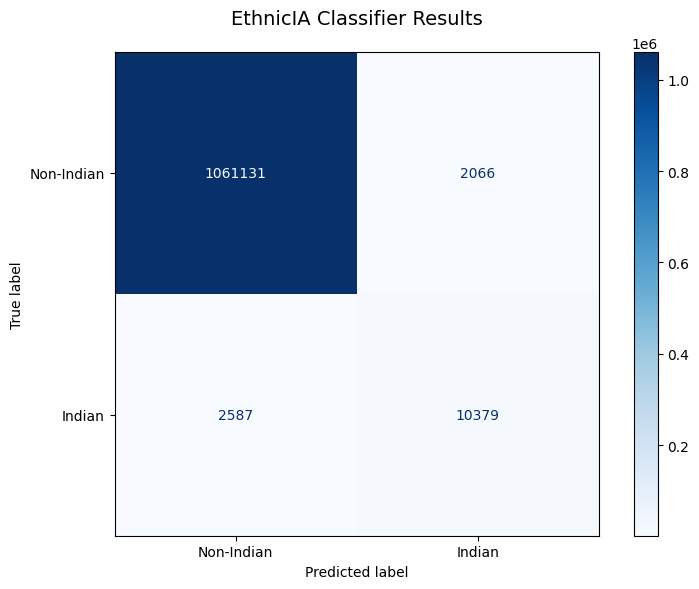

In [91]:
tp = metrics['true_positives']
fp = metrics['false_positives']
tn = metrics['true_negatives']
fn = metrics['false_negatives']
cm = np.array([[tn, fp], [fn, tp]])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                display_labels=['Non-Indian', 'Indian'])

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', ax=ax, values_format='d')
ax.set_title("EthnicIA Classifier Results", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

In [13]:
def load_model(model_path):
    
    checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
    
    # Recreate model architecture
    embedding_dim = 32
    vocab_sizes = {
        'first_name': len(checkpoint['encoder_classes']['first_name']) + 10,
        'last_name': len(checkpoint['encoder_classes']['last_name']) + 10,
        'first_name_f4': len(checkpoint['encoder_classes']['first_name_f4']) + 10,
        'last_name_f4': len(checkpoint['encoder_classes']['last_name_f4']) + 10,
        'first_name_l4': len(checkpoint['encoder_classes']['first_name_l4']) + 10,
        'last_name_l4': len(checkpoint['encoder_classes']['last_name_l4']) + 10
    }
    
    # Recreate embedding layers
    embedding_layers = {
        'first_name': torch.nn.Embedding(vocab_sizes['first_name'], embedding_dim),
        'last_name': torch.nn.Embedding(vocab_sizes['last_name'], embedding_dim),
        'first_name_f4': torch.nn.Embedding(vocab_sizes['first_name_f4'], embedding_dim // 2),
        'last_name_f4': torch.nn.Embedding(vocab_sizes['last_name_f4'], embedding_dim // 2),
        'first_name_l4': torch.nn.Embedding(vocab_sizes['first_name_l4'], embedding_dim // 2),
        'last_name_l4': torch.nn.Embedding(vocab_sizes['last_name_l4'], embedding_dim // 2)
    }
    
    # Load weights
    for name in embedding_layers.keys():
        embedding_layers[name].load_state_dict(checkpoint['embedding_layers'][name])
        embedding_layers[name].eval()
    
    # Load linear layers
    linear1 = torch.nn.Linear(checkpoint['linear1']['weight'].shape[1], checkpoint['linear2']['weight'].shape[1])
    linear2 = torch.nn.Linear(checkpoint['linear2']['weight'].shape[1], 1)
    linear1.load_state_dict(checkpoint['linear1'])
    linear2.load_state_dict(checkpoint['linear2'])
    linear1.eval()
    linear2.eval()
    
    # Recreate encoders
    encoders = {}
    for name in ['first_name', 'last_name', 'first_name_f4', 'last_name_f4', 'first_name_l4', 'last_name_l4']:
        encoder = LabelEncoder()
        encoder.classes_ = checkpoint['encoder_classes'][name]
        encoders[name] = encoder
    
    return {
        'embedding_layers': embedding_layers,
        'linear1': linear1,
        'linear2': linear2,
        'encoders': encoders,
        'feature_columns': checkpoint['feature_columns'],
        'encoded_indices': checkpoint['encoded_indices']
    }

In [14]:
def preprocess_single_name(first_name, last_name, encoders):
    
    # Extract name fragments
    first_name_f4 = str(first_name)[:4] if pd.notna(first_name) and first_name != '' else 'unknown'
    last_name_f4 = str(last_name)[:4] if pd.notna(last_name) and last_name != '' else 'unknown'
    first_name_l4 = str(first_name)[-4:] if pd.notna(first_name) and len(str(first_name)) >= 4 else 'unknown'
    last_name_l4 = str(last_name)[-4:] if pd.notna(last_name) and len(str(last_name)) >= 4 else 'unknown'
    
    first_name = 'unknown' if pd.isna(first_name) or first_name == '' else first_name
    last_name = 'unknown' if pd.isna(last_name) or last_name == '' else last_name
    
    # Encode all name components
    encoded = {}
    for encoder_name, value in [
        ('first_name', first_name),
        ('last_name', last_name),
        ('first_name_f4', first_name_f4),
        ('last_name_f4', last_name_f4),
        ('first_name_l4', first_name_l4),
        ('last_name_l4', last_name_l4)
    ]:
        encoder = encoders[encoder_name]
        try:
            encoded[encoder_name] = encoder.transform([value])[0]
        except ValueError:
            # Handle unseen names
            encoded[encoder_name] = encoder.transform(['unknown'])[0]
    
    return encoded

In [15]:
def predict_single_name(model_dict, encoded, threshold=0.5):
    
    # Create dummy numeric features (zeros) - adjust if you have actual numeric features
    numeric_features = np.zeros((1, len(model_dict['feature_columns']) - 6), dtype=np.float32)  # 6 encoded columns
    numeric_tensor = torch.tensor(numeric_features, dtype=torch.float32)
    
    # Get all embeddings
    with torch.no_grad():
        first_name_emb = model_dict['embedding_layers']['first_name'](
            torch.tensor([encoded['first_name']], dtype=torch.long)
        )
        last_name_emb = model_dict['embedding_layers']['last_name'](
            torch.tensor([encoded['last_name']], dtype=torch.long)
        )
        first_name_f4_emb = model_dict['embedding_layers']['first_name_f4'](
            torch.tensor([encoded['first_name_f4']], dtype=torch.long)
        )
        last_name_f4_emb = model_dict['embedding_layers']['last_name_f4'](
            torch.tensor([encoded['last_name_f4']], dtype=torch.long)
        )
        first_name_l4_emb = model_dict['embedding_layers']['first_name_l4'](
            torch.tensor([encoded['first_name_l4']], dtype=torch.long)
        )
        last_name_l4_emb = model_dict['embedding_layers']['last_name_l4'](
            torch.tensor([encoded['last_name_l4']], dtype=torch.long)
        )
        
        # Combine all features
        combined = torch.cat([
            numeric_tensor,
            first_name_emb,
            last_name_emb,
            first_name_f4_emb,
            last_name_f4_emb,
            first_name_l4_emb,
            last_name_l4_emb
        ], dim=1)
        
        # Forward pass
        hidden = torch.relu(model_dict['linear1'](combined))
        output = torch.sigmoid(model_dict['linear2'](hidden))
        
        probability = output.item()
        prediction = probability > threshold
        
        return prediction, probability

In [16]:
infer = load_model("./models/ethnicia_classifier_20_best.pt")
infer

{'embedding_layers': {'first_name': Embedding(98633, 32),
  'last_name': Embedding(450592, 32),
  'first_name_f4': Embedding(27444, 16),
  'last_name_f4': Embedding(51515, 16),
  'first_name_l4': Embedding(26054, 16),
  'last_name_l4': Embedding(48417, 16)},
 'linear1': Linear(in_features=128, out_features=128, bias=True),
 'linear2': Linear(in_features=128, out_features=1, bias=True),
 'encoders': {'first_name': LabelEncoder(),
  'last_name': LabelEncoder(),
  'first_name_f4': LabelEncoder(),
  'last_name_f4': LabelEncoder(),
  'first_name_l4': LabelEncoder(),
  'last_name_l4': LabelEncoder()},
 'feature_columns': ['first_name_encoded',
  'last_name_encoded',
  'first_name_f4_encoded',
  'last_name_f4_encoded',
  'first_name_l4_encoded',
  'last_name_l4_encoded'],
 'encoded_indices': {'first_name_encoded': 0,
  'last_name_encoded': 1,
  'first_name_f4_encoded': 2,
  'last_name_f4_encoded': 3,
  'first_name_l4_encoded': 4,
  'last_name_l4_encoded': 5}}

In [17]:
# fix the thing where it can't handle unseen names
pred, prob = predict_single_name(infer, preprocess_single_name("mahmood", "khan", infer["encoders"]))
pred, prob

(False, 6.736971727150376e-07)

In [160]:
def predict_df(donors, infer, threshold=0.5):
    
    print("Preprocessing names...")
    donors = donors.copy()
    
    donors['firstname'] = donors['firstname'].fillna('unknown')
    donors['lastname'] = donors['lastname'].fillna('unknown')
    donors['first_name_f4'] = donors['firstname'].str[:4].fillna('unknown')
    donors['last_name_f4'] = donors['lastname'].str[:4].fillna('unknown')
    donors['first_name_l4'] = donors['firstname'].str[-4:].fillna('unknown')
    donors['last_name_l4'] = donors['lastname'].str[-4:].fillna('unknown')
    donors = donors[(donors['firstname'] != 'unknown') & (donors['lastname'] != 'unknown')]
    
    # Encode all names vectorized
    encoders = infer['encoders']
    encoded_data = {}
    for col, encoder_name in [
        ('firstname', 'first_name'),
        ('lastname', 'last_name'),
        ('first_name_f4', 'first_name_f4'),
        ('last_name_f4', 'last_name_f4'),
        ('first_name_l4', 'first_name_l4'),
        ('last_name_l4', 'last_name_l4')
    ]:
        
        encoder = encoders[encoder_name]
        # Map unseen values to 'unknown'
        try:
            valid_mask = donors[col].isin(encoder.classes_)
            encoded_col = donors[col].where(valid_mask, 'unknown')
            encoded_data[encoder_name] = encoder.transform(encoded_col)
        except:
            print(col)
            print(encoder_name)
            print(pd.Series(valid_mask).value_counts())
    
    # Convert to tensors
    print("Converting to tensors...")
    # Create numeric features tensor (zeros if no numeric features)
    numeric_features = np.zeros((len(donors), len(infer['feature_columns']) - 6), dtype=np.float32)
    numeric_tensor = torch.tensor(numeric_features, dtype=torch.float32)
    
    # Create all embedding tensors
    embedding_tensors = []
    for encoder_name in ['first_name', 'last_name', 'first_name_f4', 'last_name_f4', 'first_name_l4', 'last_name_l4']:
        ids_tensor = torch.tensor(encoded_data[encoder_name], dtype=torch.long)
        emb_layer = infer['embedding_layers'][encoder_name]
        with torch.no_grad():
            emb_tensor = emb_layer(ids_tensor)
        embedding_tensors.append(emb_tensor)
    
    # Combine all features
    print("Running model predictions...")
    with torch.no_grad():
        combined = torch.cat([numeric_tensor] + embedding_tensors, dim=1)
        hidden = torch.relu(infer['linear1'](combined))
        outputs = torch.sigmoid(infer['linear2'](hidden))
        probabilities = outputs.squeeze().numpy()
    
    # Apply threshold
    predictions = probabilities > threshold
    
    # Add results to DataFrame
    donors['model'] = predictions
    donors['model_prob'] = probabilities
    donors.drop(['first_name_f4', 'last_name_f4', 'first_name_l4', 'last_name_l4'], axis=1, inplace=True, errors='ignore')
    
    print("Classification complete!")
    
    # Print summary
    indian_count = predictions.sum()
    total_count = len(donors)
    print(f"\nIndian names: {indian_count} ({indian_count/total_count*100:.2f}%)")
    print(f"Non-Indian names: {total_count - indian_count} ({(total_count - indian_count)/total_count*100:.2f}%)")
    
    return donors

In [161]:
donors_pred = predict_df(donors, infer)
donors_pred["model"].value_counts()

Preprocessing names...
first_name_f4
first_name_f4
first_name_f4
True     3532459
False      56461
Name: count, dtype: int64
last_name_f4
last_name_f4
last_name_f4
True     3588717
False        203
Name: count, dtype: int64
first_name_l4
first_name_l4
first_name_l4
True     2893303
False     695617
Name: count, dtype: int64
last_name_l4
last_name_l4
last_name_l4
True     3588717
False        203
Name: count, dtype: int64
Converting to tensors...


KeyError: 'first_name_f4'